In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

#data = pd.read_csv('BBM.csv')
data = pd.read_excel('Final.xlsx', sheet_name = ['Premium','Solar'])
#df1 = pd.read_excel(data, 'Premium')

data

{'Premium':         Tanggal       qty     Jumlah
 0    2016-01-01   8694.00   63467076
 1    2016-01-02  10043.84   73320032
 2    2016-01-03  13927.56  101671188
 3    2016-01-04  12518.27   91382972
 4    2016-01-05  11111.57   77424375
 ...         ...       ...        ...
 1456 2019-12-27  15916.00  102658200
 1457 2019-12-28  15880.00  102434000
 1458 2019-12-29  15860.00  102297000
 1459 2019-12-30  15901.00  102561450
 1460 2019-12-31  15874.00  102387300
 
 [1461 rows x 3 columns],
 'Solar':         Tanggal      qty    Jumlah
 0    2016-01-01   835.96   5600932
 1    2016-01-02   964.23   6460341
 2    2016-01-03  1899.70  12727990
 3    2016-01-04  1943.87  13023929
 4    2016-01-05  7652.83  43238490
 ...         ...      ...       ...
 1456 2019-12-27  8715.00  44882250
 1457 2019-12-28  9413.00  48476950
 1458 2019-12-29  8936.00  46020400
 1459 2019-12-30  8887.00  45768050
 1460 2019-12-31  8746.00  45041900
 
 [1461 rows x 3 columns]}

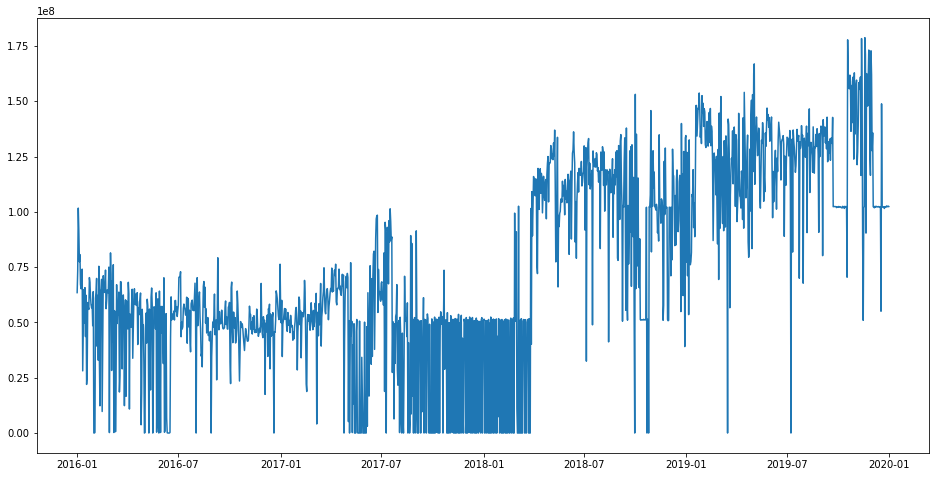

In [39]:
# Mengatur Tanggal dan Data
df['Tanggal'] = pd.to_datetime(df.Tanggal, format='%Y-%m-%d')
df.index = df['Tanggal']

#Plot
plt.figure(figsize=(16,8))
plt.plot(df['Jumlah'],label='History Harga Penutup')

In [40]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM

#Membuat Matrix 2 Dimensi
data = df.sort_index(ascending=True,axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Tanggal','Jumlah'])
for i in range(0,len(df)):
    new_data['Tanggal'][i] = data['Tanggal'][i]
    new_data['Jumlah'][i] = data['Jumlah'][i]
    
#Membuat Tanggal menjadi Index di variable new_data
new_data.index = new_data['Tanggal']
new_data.drop('Tanggal',axis=1,inplace=True)

#Membuat Data Latih dan Test
#Menampung Data Untuk dijadikan Data olah
dataset = new_data.values 
#Membuat data latih
train = dataset[0:500,:]
#Membuat Data Uji
valid = dataset[500:,:]
 
    

In [41]:
#Normalisasi Data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

x_train,y_train = [],[]
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train,y_train = np.array(x_train),np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

print(x_train)


[[[0.35513974]
  [0.41027346]
  [0.5689167 ]
  ...
  [0.41962472]
  [0.00112353]
  [0.36373153]]

 [[0.41027346]
  [0.5689167 ]
  [0.51134741]
  ...
  [0.00112353]
  [0.36373153]
  [0.45565844]]

 [[0.5689167 ]
  [0.51134741]
  [0.43323994]
  ...
  [0.36373153]
  [0.45565844]
  [0.40191391]]

 ...

 [[0.32936421]
  [0.37831415]
  [0.2199206 ]
  ...
  [0.28267225]
  [0.00111913]
  [0.22330097]]

 [[0.37831415]
  [0.2199206 ]
  [0.29326055]
  ...
  [0.00111913]
  [0.22330097]
  [0.07406071]]

 [[0.2199206 ]
  [0.29326055]
  [0.31086224]
  ...
  [0.22330097]
  [0.07406071]
  [0.27646443]]]


In [42]:
# Membuat Model dan fit LSTM Network

model = Sequential()
model.add(LSTM(units=68,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=68))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(x_train,y_train,epochs=1,batch_size=1,verbose=2)

440/440 - 7s - loss: 0.0096 - 7s/epoch - 16ms/step


In [43]:
#Prediksi 246 Values dengan 60 Data Train
inputs = new_data[len(new_data)-len(valid)-60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(60,inputs.shape[0]):
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

closing_price = model.predict(x_test)
closing_price = scaler.inverse_transform(closing_price)

31/31 [==============================] - 1s 10ms/step


In [44]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

28206091.33843786

C:\Users\USER\AppData\Local\Temp\ipykernel_8884\3102028518.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


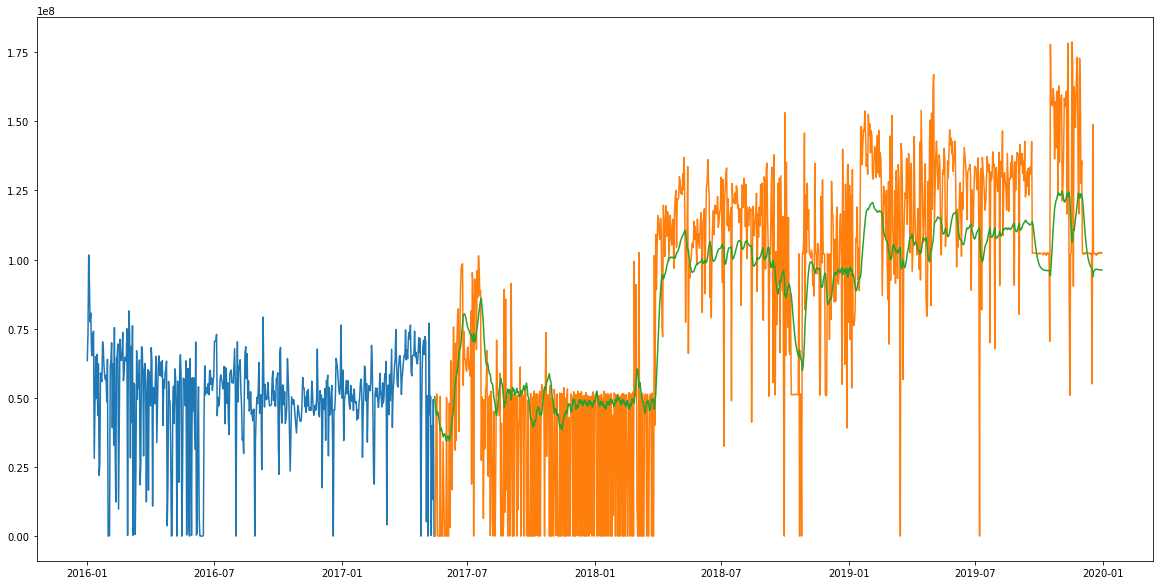

In [46]:
#Chart Grafik
train = new_data[:500]
valid = new_data[500:]

valid['Predictions'] = closing_price
plt.plot(train['Jumlah'])
plt.plot(valid[['Jumlah','Predictions']])